In [1]:
from torch.nn import Module
from torch.nn import Conv2d
from torch.nn import Linear
from torch.nn import MaxPool2d
from torch.nn import ReLU
from torch.nn import LogSoftmax
from torch import flatten

(3, 30, 30)


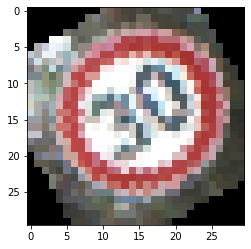

In [29]:
def show5(img_loader):
    dataiter = iter(img_loader)
    
    batch = next(dataiter)
    labels = batch[1][0:10]
    images = batch[0][0:10]
    for i in range(10):
        print(labels[i])
        image = images[i].numpy()
        print(image.shape)
        plt.imshow(np.rot90(image.T, k=3))
        plt.show()
        
# show5(trainDataLoader)
print(trainData[2][0:10][0].numpy().shape)
plt.imshow(np.rot90(trainData[2][0:10][0].numpy().T, k=3))
plt.show()

In [30]:
class LeNet(Module):
    def __init__(self, numChannels, classes):
        # call the parent constructor
        super(LeNet, self).__init__()
        # initialize first set of CONV => RELU => POOL layers
        self.conv1 = Conv2d(in_channels=numChannels, out_channels=20,
            kernel_size=(5, 5))
        self.relu1 = ReLU()
        self.maxpool1 = MaxPool2d(kernel_size=(2, 2), stride=(2, 2))
        # initialize second set of CONV => RELU => POOL layers
        self.conv2 = Conv2d(in_channels=20, out_channels=50,
            kernel_size=(5, 5))
        self.relu2 = ReLU()
        self.maxpool2 = MaxPool2d(kernel_size=(2, 2), stride=(2, 2))
        # initialize first (and only) set of FC => RELU layers
        self.fc1 = Linear(in_features=4320, out_features=3774)
        self.relu3 = ReLU()
        # initialize our softmax classifier
        self.fc2 = Linear(in_features=3774, out_features=classes)
        self.logSoftmax = LogSoftmax(dim=1)

In [3]:
import matplotlib
# import the necessary packages
from sklearn.metrics import classification_report
from torch.utils.data import random_split
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
from torchvision.datasets import GTSRB
from torch.optim import Adam
from torch import nn
import matplotlib.pyplot as plt
import numpy as np
import argparse
import torch
import time

In [4]:
ap = argparse.ArgumentParser()
ap.add_argument("-m", "--model", type=str, required=True,
help="path to output trained model")
ap.add_argument("-p", "--plot", type=str, required=True,
help="path to output loss/accuracy plot")
args = vars(ap.parse_args())

usage: ipykernel_launcher.py [-h] -m MODEL -p PLOT
ipykernel_launcher.py: error: the following arguments are required: -m/--model, -p/--plot


SystemExit: 2

C:\Users\ALHeL\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3452: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [8]:
INIT_LR = 1e-3
BATCH_SIZE = 64
EPOCHS = 10
# define the train and val splits
TRAIN_SPLIT = 0.75
VAL_SPLIT = 1 - TRAIN_SPLIT
# set the device we will be using to train the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [27]:
import torchvision.transforms as transforms

train_transform_list = [
                        transforms.Resize((30,30)),
                        transforms.RandomRotation(30),
                        transforms.RandomHorizontalFlip(),
                        transforms.ToTensor()
                       ]

test_transform_list = [
                        transforms.Resize((30,30)),
                        transforms.ToTensor()
                      ]

train_transform = transforms.Compose(train_transform_list)
test_transform = transforms.Compose(test_transform_list)

In [28]:
print("[INFO] loading the GTSRB dataset...")
trainData = GTSRB(root="data", download=True,
    transform=train_transform)
testData = GTSRB(root="data", download=True,
    transform=test_transform)
# calculate the train/validation split
print("[INFO] generating the train/validation split...")
numTrainSamples = int(len(trainData) * TRAIN_SPLIT)
numValSamples = int(len(trainData) * VAL_SPLIT)
(trainData, valData) = random_split(trainData,
    [numTrainSamples, numValSamples],
    generator=torch.Generator().manual_seed(42))

[INFO] loading the GTSRB dataset...
[INFO] generating the train/validation split...


In [11]:
trainDataLoader = DataLoader(trainData, shuffle=True,
batch_size=BATCH_SIZE)
valDataLoader = DataLoader(valData, batch_size=BATCH_SIZE)
testDataLoader = DataLoader(testData, batch_size=BATCH_SIZE)
# calculate steps per epoch for training and validation set
trainSteps = len(trainDataLoader.dataset) // BATCH_SIZE
valSteps = len(valDataLoader.dataset) // BATCH_SIZE

In [12]:
print("[INFO] initializing the LeNet model...")
model = LeNet(
    numChannels=3,
    classes=43).to(device)
# initialize our optimizer and loss function
opt = Adam(model.parameters(), lr=INIT_LR)
lossFn = nn.NLLLoss()
# initialize a dictionary to store training history
H = {
    "train_loss": [],
    "train_acc": [],
    "val_loss": [],
    "val_acc": []
}
# measure how long training is going to take
print("[INFO] training the network...")
startTime = time.time()

[INFO] initializing the LeNet model...
[INFO] training the network...


In [13]:
for e in range(0, EPOCHS):
    # set the model in training mode
    model.train()
    # initialize the total training and validation loss
    totalTrainLoss = 0
    totalValLoss = 0
    # initialize the number of correct predictions in the training
    # and validation step
    trainCorrect = 0
    valCorrect = 0
    # loop over the training set
    for (x, y) in trainDataLoader:
        # send the input to the device
        (x, y) = (x.to(device), y.to(device))
        # perform a forward pass and calculate the training loss
        pred = model(x)
        loss = lossFn(pred, y)
        # zero out the gradients, perform the backpropagation step,
        # and update the weights
        opt.zero_grad()
        loss.backward()
        opt.step()
        # add the loss to the total training loss so far and
        # calculate the number of correct predictions
        totalTrainLoss += loss
        trainCorrect += (pred.argmax(1) == y).type(
            torch.float).sum().item()

RuntimeError: stack expects each tensor to be equal size, but got [3, 29, 30] at entry 0 and [3, 43, 43] at entry 2